In [2]:
import numpy as np
import collections
import heapq


In [3]:
initial_layout = [['📙','📘','📗','📘','📙','📗','📙'],
                  ['📕','📗','📕','📘','📕','📘','📙'],
                  ['📙','📘','📗','📗','📙','📘','📗'],
                  ['📘','📗','📘','📘','📙','📕','📕'],
                  ['📕','📗','📘','📙','📙','📘','📘'],
                  ['📙','📘','📗','📕','📙','📘','📙'],
                  ['📕','📕','📙','📕','📘','📙','📗'],
                  ['📗','📗','📕','📗','📗','📙','📗'],
                  ['📗','📕','📘','📘','📘','📕','📘']]
layout_dict = {'📙':1,
               '📘':2,
               '📗':3,
               '📕':4,}
print_dict = {1:'📙',
               2:'📘',
               3:'📗',
               4:'📕',
               0:'  '}



In [4]:
import networkx as nx


In [5]:
game_dict = {}
board_size = np.array(initial_layout).shape
for i in range(board_size[0]):
    for j in range(board_size[1]):
        number = layout_dict[initial_layout[i][j]]
        game_dict[i,j] = number

In [5]:
# Bad code
def group_tiles():
    group_network_dict = {1:[],
                      2:[],
                      3:[],
                      4:[]}

    for i,j in game_dict:
        tile = game_dict[i,j]
        if tile:
            check_coords = [[i+1,j],
                            [i-1,j],
                            [i,j+1],
                            [i,j-1]]
            G = nx.Graph()
            G.add_node(f'{i}_{j}')
            for c in check_coords:
                if (c[0],c[1]) in game_dict:
                    if game_dict[c[0],c[1]] == tile:
                        G.add_node(f'{c[0]}_{c[1]}')
                        G.add_edge(f'{i}_{j}',f'{c[0]}_{c[1]}')
            group_network_dict[tile].append(G)

    for tile in layout_dict.values():
        G_compose = nx.Graph()
        for G in group_network_dict[tile]:
            G_compose = nx.compose(G_compose,G)
        group_network_dict[tile] = list(nx.connected_components(G_compose))


    return group_network_dict


        

In [6]:
def clear_tiles(i,j,clear_tile):
   #print(i,j)
   if i<0 or i>board_size[0] or j < 0 or j>board_size[1]:
      return
   tile = game_dict[i,j]
   if tile != clear_tile:
      return
   #print('cleared')
   game_dict[i,j] = 0
   clear_tiles(i-1,j,clear_tile)
   clear_tiles(i+1,j,clear_tile)
   clear_tiles(i,j-1,clear_tile)
   clear_tiles(i,j+1,clear_tile)
      

In [7]:
def update_board():
    
    for j in range(board_size[1]-1):
        empty_spaces = 0
        for i in range(board_size[0]-1,-1,-1):
            if game_dict[i,j] == 0:
                empty_spaces +=1
            elif empty_spaces>0:
                game_dict[i+empty_spaces,j] = game_dict[i,j]
                game_dict[i,j] = 0

    return game_dict

        

In [8]:
game_dict = update_board()

In [9]:
clear_tiles(2,4,game_dict[2,4])


In [10]:
game_dict = update_board()

In [11]:
def print_board():
    for i in range(board_size[0]):
        row_print = []
        for j in range(board_size[1]):

            tile = game_dict[i,j]
            row_print.append(print_dict[tile])
        print(row_print)

In [12]:
print_board()

['📙', '📘', '📗', '  ', '  ', '📗', '📙']
['📕', '📗', '📕', '📘', '  ', '📘', '📙']
['📙', '📘', '📗', '📘', '  ', '📘', '📗']
['📘', '📗', '📘', '📗', '  ', '📕', '📕']
['📕', '📗', '📘', '📘', '📙', '📘', '📘']
['📙', '📘', '📗', '📕', '📕', '📘', '📙']
['📕', '📕', '📙', '📕', '📘', '📙', '📗']
['📗', '📗', '📕', '📗', '📗', '📙', '📗']
['📗', '📕', '📘', '📘', '📘', '📕', '📘']


In [13]:
game_array = np.zeros(board_size)

In [14]:
game_array.shape

(9, 7)

In [15]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import utils

#from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [33]:
class GameEnvironment():

    def __init__(self,initial_layout):
        super().__init__()
        layout_dict = {'📙':1,
                       '📘':2,
                       '📗':3,
                       '📕':4,}
        
        board_size = np.array(initial_layout).shape

        action_map = {}
        game_array = np.zeros(board_size)
        action_number = 0
        for i in range(board_size[0]):
            for j in range(board_size[1]):
                number = layout_dict[initial_layout[i][j]]
                game_array[i,j] = number
                action_map[action_number] = [i,j]
                action_number += 1


        self.action_space = np.zeros(shape=(len(action_map)))
        self.obaservation_space = np.zeros(shape = (board_size[0]*board_size[1]))
        self.episode_ended = False
        
        self.initial_game_array = game_array.astype(int).copy()
        self.game_array = game_array.astype(int).copy()
        self.board_size = board_size
        self.action_map = action_map
        self.n_actions = 0
        self.n_remaining = np.sum(self.game_array!=0)
    

    def reset(self):
        self.game_array = np.random.randint(1,5,size=self.game_array.shape)
        #print(self.initial_game_array)
        self.episode_ended = False
        self.n_actions = 0
        initial_state = self.game_array.reshape(-1,1).astype(int)[:,0]
        self.n_remaining = np.sum(self.game_array!=0)
        return initial_state
    
    def reset_test(self):
        self.game_array = self.initial_game_array.copy()
        #print(self.initial_game_array)
        self.episode_ended = False
        self.n_actions = 0
        initial_state = self.game_array.reshape(-1,1).astype(int)[:,0]
        self.n_remaining = np.sum(self.game_array!=0)
        return initial_state
    
    def step(self, action):
        def clear_tiles(self,i,j,clear_tile):
            #print(i,j)
            if i<0 or i>=board_size[0] or j < 0 or j>=board_size[1]:
                return
            tile = self.game_array[i,j]
            if tile != clear_tile or clear_tile==0:
                return
            #print('cleared')
            self.game_array[i,j] = 0
            clear_tiles(self,i-1,j,clear_tile)
            clear_tiles(self,i+1,j,clear_tile)
            clear_tiles(self,i,j-1,clear_tile)
            clear_tiles(self,i,j+1,clear_tile)

        def update_board(self):
            for j in range(board_size[1]):
                empty_spaces = 0
                for i in range(board_size[0]-1,-1,-1):
                    if self.game_array[i,j] == 0:
                        empty_spaces +=1
                    elif empty_spaces>0:
                        self.game_array[i+empty_spaces,j] = self.game_array[i,j]
                        self.game_array[i,j] = 0

        i = self.action_map[int(action)][0]
        j = self.action_map[int(action)][1]
        clear_tile = int(self.game_array[i,j])
        self.n_actions += 1
        #if self.episode_ended:
        #    # The last action ended the episode. Ignore the current action and start
        #    # a new episode.
        #    return self.reset()
        
        if clear_tile!=0:
            clear_tiles(self,i,j,clear_tile)
            update_board(self)


        reward = -1
        if clear_tile == 0:
            reward += -100

        n_cleared = self.n_remaining- np.sum(self.game_array!=0)
        self.n_remaining = np.sum(self.game_array!=0)
        #if n_cleared ==1:
        #    reward += -10
        next_state = self.game_array.reshape(-1,1).astype(int)[:,0]

        max_actions = 30
        if np.all(self.game_array==0) or self.n_actions>max_actions:
            self.episode_ended = True
            #if self.n_actions<max_actions:
            #    reward += (max_actions - self.n_actions)**2
            if ~np.all(self.game_array==0):
                reward += -100
            return next_state,reward,self.episode_ended
        else:
            return next_state,reward,self.episode_ended
        
    def print_board(self):
        for i in range(self.board_size[0]):
            row_print = []
            for j in range(self.board_size[1]):

                tile = self.game_array[i,j]
                row_print.append(print_dict[tile])
            print(row_print)


In [34]:
env = GameEnvironment(initial_layout)

In [35]:
state_size = env.obaservation_space.shape
num_actions = env.obaservation_space.shape[0]

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (63,)
Number of actions: 63


In [36]:
# Reset the environment and get the initial state.
current_state = env.reset()

In [37]:
# Select an action
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, done = env.step(action)
env.print_board()
current_state = next_state

['  ', '📗', '📙', '📙', '📙', '📙', '📗']
['📙', '📕', '📘', '📘', '📙', '📗', '📕']
['📕', '📙', '📗', '📙', '📗', '📘', '📗']
['📕', '📘', '📗', '📕', '📕', '📘', '📕']
['📘', '📕', '📗', '📕', '📗', '📗', '📗']
['📘', '📘', '📕', '📙', '📕', '📕', '📕']
['📗', '📗', '📗', '📕', '📙', '📕', '📕']
['📕', '📙', '📙', '📗', '📙', '📘', '📗']
['📕', '📗', '📙', '📘', '📙', '📙', '📗']


In [38]:
state_size

(63,)

In [46]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [ ]:
ALPHA = 1e-3              # learning rate  

# Create the Q-Network
q_network = Sequential([
    Input(shape=state_size), 
    Dense(units=128,activation='relu'),
    Dense(units=128,activation='relu'),
    Dense(units=num_actions,activation='linear')
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(shape=state_size), 
    Dense(units=128,activation='relu'),
    Dense(units=128,activation='relu'),
    Dense(units=num_actions,activation='linear')    
    ])

optimizer = Adam(learning_rate=ALPHA)

In [48]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.

    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences

    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    y_targets = (done_vals)*rewards + (1-done_vals)*(rewards+gamma*max_qsa)

    # Get the q_values and reshape to match y_targets
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Compute the loss
    loss = MSE(y_targets,q_values) 

    return loss

In [49]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    utils.update_target_network(q_network, target_q_network)

In [67]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.99            # discount factor
NUM_STEPS_FOR_UPDATE = 5  # perform a learning update every C time steps
E_DECAY = 0.999  # ε-decay rate for the ε-greedy policy.
E_MIN = 0.01  # Minimum ε value for the ε-greedy policy.

num_episodes = 5000

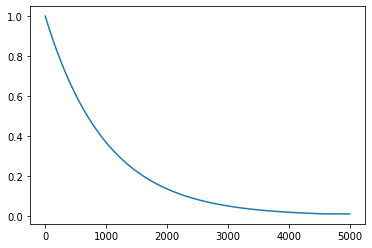

In [68]:
epsilon_list = list()
epsilon = 1
epsilon_list.append(epsilon)
for i in range(num_episodes):
    # Update the ε value
    epsilon = utils.get_new_eps(epsilon,E_MIN,E_DECAY)
    epsilon_list.append(epsilon)
plt.plot(range(num_episodes+1),epsilon_list)

In [69]:
start = time.time()

max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())
best_action = list()
best_return = -1000
for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    state = env.reset_test()
    total_points = 0
    action_list = list()
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        
        action = utils.get_action(q_values, state, epsilon)
        action_list.append(action)

        # Take action A and receive reward R and the next state S'
        next_state, reward, done = env.step(action)
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)
            
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    if total_points>best_return:
        best_action = action_list
        best_return = total_points

    # Update the ε value
    epsilon = utils.get_new_eps(epsilon,E_MIN,E_DECAY)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -34.79
Episode 200 | Total point average of the last 100 episodes: -37.04
Episode 300 | Total point average of the last 100 episodes: -32.69
Episode 400 | Total point average of the last 100 episodes: -31.45
Episode 500 | Total point average of the last 100 episodes: -28.43
Episode 600 | Total point average of the last 100 episodes: -30.83
Episode 700 | Total point average of the last 100 episodes: -27.00
Episode 800 | Total point average of the last 100 episodes: -29.02
Episode 900 | Total point average of the last 100 episodes: -28.91
Episode 1000 | Total point average of the last 100 episodes: -29.59
Episode 1100 | Total point average of the last 100 episodes: -28.97
Episode 1200 | Total point average of the last 100 episodes: -27.12
Episode 1300 | Total point average of the last 100 episodes: -26.70
Episode 1400 | Total point average of the last 100 episodes: -26.16
Episode 1500 | Total point average of the last 100 episod

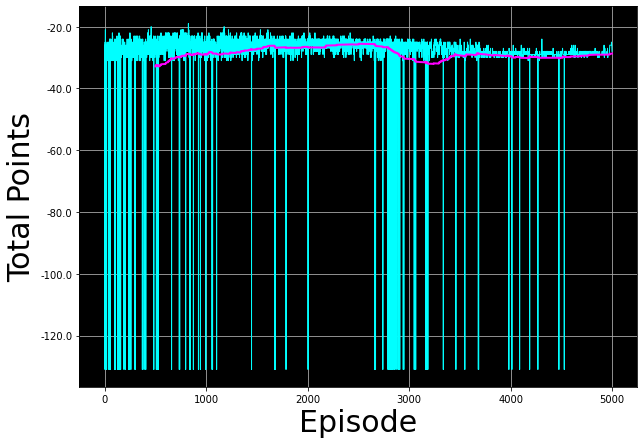

In [70]:
utils.plot_history(total_point_history)

In [71]:
# Reset the environment to the initial state and get the initial state
state = env.reset_test()
total_points = 0
env.print_board()
for t,action in enumerate(best_action):
    
    # Take action A and receive reward R and the next state S'
    next_state, reward, done = env.step(action)
    
    state = next_state.copy()
    total_points += reward
    env.print_board()
    print(t)
    if done:
        break

print('Final Score',t)

['📙', '📘', '📗', '📘', '📙', '📗', '📙']
['📕', '📗', '📕', '📘', '📕', '📘', '📙']
['📙', '📘', '📗', '📗', '📙', '📘', '📗']
['📘', '📗', '📘', '📘', '📙', '📕', '📕']
['📕', '📗', '📘', '📙', '📙', '📘', '📘']
['📙', '📘', '📗', '📕', '📙', '📘', '📙']
['📕', '📕', '📙', '📕', '📘', '📙', '📗']
['📗', '📗', '📕', '📗', '📗', '📙', '📗']
['📗', '📕', '📘', '📘', '📘', '📕', '📘']
['📙', '📘', '  ', '  ', '  ', '📗', '📙']
['📕', '📗', '📗', '📘', '📙', '📘', '📙']
['📙', '📘', '📕', '📘', '📕', '📘', '📗']
['📘', '📗', '📗', '📗', '📙', '📕', '📕']
['📕', '📗', '📘', '📘', '📙', '📘', '📘']
['📙', '📘', '📘', '📙', '📙', '📘', '📙']
['📕', '📕', '📗', '📕', '📙', '📙', '📗']
['📗', '📗', '📙', '📕', '📘', '📙', '📗']
['📗', '📕', '📕', '📗', '📗', '📕', '📘']
0
['📙', '📘', '  ', '  ', '  ', '📗', '  ']
['📕', '📗', '📗', '📘', '📙', '📘', '  ']
['📙', '📘', '📕', '📘', '📕', '📘', '📙']
['📘', '📗', '📗', '📗', '📙', '📕', '📙']
['📕', '📗', '📘', '📘', '📙', '📘', '📗']
['📙', '📘', '📘', '📙', '📙', '📘', '📕']
['📕', '📕', '📗', '📕', '📙', '📙', '📘']
['📗', '📗', '📙', '📕', '📘', '📙', '📙']
['📗', '📕', '📕', '📗', '📗', '📕', '📘']
1
['📙', '📘', '  ',

In [ ]:
# Reset the environment to the initial state and get the initial state
state = env.reset_test()
total_points = 0
env.print_board()
for t in enumerate(max_num_timesteps):
    
    # From the current state S choose an action A using an ε-greedy policy
    state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
    q_values = q_network(state_qn)
    
    action = utils.get_action(q_values, state)
    
    # Take action A and receive reward R and the next state S'
    next_state, reward, done = env.step(action)
    
    state = next_state.copy()
    total_points += reward
    env.print_board()
    print(t)
    if done:
        break

print('Final Score',t)

['📙', '📘', '📗', '📘', '📙', '📗', '📙']
['📕', '📗', '📕', '📘', '📕', '📘', '📙']
['📙', '📘', '📗', '📗', '📙', '📘', '📗']
['📘', '📗', '📘', '📘', '📙', '📕', '📕']
['📕', '📗', '📘', '📙', '📙', '📘', '📘']
['📙', '📘', '📗', '📕', '📙', '📘', '📙']
['📕', '📕', '📙', '📕', '📘', '📙', '📗']
['📗', '📗', '📕', '📗', '📗', '📙', '📗']
['📗', '📕', '📘', '📘', '📘', '📕', '📘']
['📙', '  ', '📗', '📘', '📙', '📗', '📙']
['📕', '  ', '📕', '📘', '📕', '📘', '📙']
['📙', '📘', '📗', '📗', '📙', '📘', '📗']
['📘', '📗', '📘', '📘', '📙', '📕', '📕']
['📕', '📘', '📘', '📙', '📙', '📘', '📘']
['📙', '📘', '📗', '📕', '📙', '📘', '📙']
['📕', '📕', '📙', '📕', '📘', '📙', '📗']
['📗', '📗', '📕', '📗', '📗', '📙', '📗']
['📗', '📕', '📘', '📘', '📘', '📕', '📘']
0
['📙', '  ', '  ', '  ', '📙', '📗', '📙']
['📕', '  ', '  ', '📘', '📕', '📘', '📙']
['📙', '  ', '📗', '📘', '📙', '📘', '📗']
['📘', '  ', '📕', '📗', '📙', '📕', '📕']
['📕', '📘', '📗', '📙', '📙', '📘', '📘']
['📙', '📗', '📗', '📕', '📙', '📘', '📙']
['📕', '📕', '📙', '📕', '📘', '📙', '📗']
['📗', '📗', '📕', '📗', '📗', '📙', '📗']
['📗', '📕', '📘', '📘', '📘', '📕', '📘']
1
['📙', '  ', '  

In [1]:
class GraphEnvironment():

    def __init__(self,initial_layout):
        super().__init__()
        layout_dict = {'📙':1,
                       '📘':2,
                       '📗':3,
                       '📕':4,}
        
        board_size = np.array(initial_layout).shape

        action_map = {}
        game_array = np.zeros(board_size)
        action_number = 0
        for i in range(board_size[0]):
            for j in range(board_size[1]):
                number = layout_dict[initial_layout[i][j]]
                game_array[i,j] = number
                action_map[action_number] = [i,j]
                action_number += 1

        self.action_space = np.zeros(shape=(len(action_map)))
        self.obaservation_space = np.zeros(shape = (board_size[0]*board_size[1]))
        self.episode_ended = False
        
        self.initial_game_array = game_array.astype(int).copy()
        self.game_array = game_array.astype(int).copy()
        self.board_size = board_size
        self.action_map = action_map
        self.n_actions = 0
        self.n_remaining = np.sum(self.game_array!=0)    



    def step(self, game_array_code, action):
        
        self.game_array = np.array(list(int(c) for c in game_array_code)).reshape(board_size[0],board_size[1])

        def clear_tiles(self,i,j,clear_tile):
            #print(i,j)
            if i<0 or i>=board_size[0] or j < 0 or j>=board_size[1]:
                return
            tile = self.game_array[i,j]
            if tile != clear_tile or clear_tile==0:
                return
            #print('cleared')
            self.game_array[i,j] = 0
            clear_tiles(self,i-1,j,clear_tile)
            clear_tiles(self,i+1,j,clear_tile)
            clear_tiles(self,i,j-1,clear_tile)
            clear_tiles(self,i,j+1,clear_tile)

        def update_board(self):
            for j in range(board_size[1]):
                empty_spaces = 0
                for i in range(board_size[0]-1,-1,-1):
                    if self.game_array[i,j] == 0:
                        empty_spaces +=1
                    elif empty_spaces>0:
                        self.game_array[i+empty_spaces,j] = self.game_array[i,j]
                        self.game_array[i,j] = 0

        i = self.action_map[int(action)][0]
        j = self.action_map[int(action)][1]
        clear_tile = int(self.game_array[i,j])
        
        if clear_tile!=0:
            clear_tiles(self,i,j,clear_tile)
            update_board(self)

        next_state = self.game_array.reshape(-1,1).astype(int)[:,0]
        
        code = ''
        for c in next_state:
            code += str(c)
        return code
    
    def calc_heuristic(self,game_array_code):
        self.game_array = np.array(list(int(c) for c in game_array_code)).reshape(board_size[0],board_size[1])
        n_tiles = np.sum(self.game_array!=0)
        if True:
            groups_dict = collections.defaultdict(int)
            
            n_moves = collections.defaultdict(int)
            self.game_array = np.array(list(int(c) for c in game_array_code)).reshape(board_size[0],board_size[1])
            unique_tiles = set(game_array_code) - set('0')
            for i in unique_tiles:
                column_list = np.any(self.game_array==int(i),axis=0)
                value = column_list[0]
                moves = 0
                for c in column_list:
                    if c != value:
                        moves += 1
                    value = c
                n_moves[i] = moves
        
        def clear_tiles(self,i,j,clear_tile):
            #print(i,j)
            if i<0 or i>=board_size[0] or j < 0 or j>=board_size[1]:
                return
            tile = self.game_array[i,j]
            if tile != clear_tile or clear_tile==0:
                return
            #print('cleared')
            self.game_array[i,j] = 0
            clear_tiles(self,i-1,j,clear_tile)
            clear_tiles(self,i+1,j,clear_tile)
            clear_tiles(self,i,j-1,clear_tile)
            clear_tiles(self,i,j+1,clear_tile)

        if False:
            current_tiles = n_tiles.copy()
            group_size = []
            for action in self.action_map.keys():
            
                i = self.action_map[int(action)][0]
                j = self.action_map[int(action)][1]
                clear_tile = int(self.game_array[i,j])
                
                if clear_tile!=0:
                    clear_tiles(self,i,j,clear_tile)
                    tile_count = np.sum(self.game_array!=0)

                    group_size.append(current_tiles - tile_count)
                    current_tiles = tile_count

            #print(group_size)
            average_group_size = np.mean(np.array(group_size))+5
        #print(average_group_size)
        if False:
            min_tile = min(groups_dict,key=groups_dict.get)
            #print(min_tile)
            unique_tiles = unique_tiles - set(str(min_tile))
            #print(groups_dict)
            #print(n_moves)
            for i in unique_tiles:
                groups_dict[i] = max(min(groups_dict[i],n_moves[i]),1)

            #print(groups_dict)

        return sum(n_moves.values())

In [475]:
g_env = GraphEnvironment(initial_layout)
g_env.calc_heuristic(code)

[1, 1, 2, 1, 1, 2, 1, 1, 5, 5, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 2, 1, 1, 2, 2, 3, 1, 2, 1, 3, 1, 1]
6.65625


7.962441314553991

In [451]:
np.array(list(int(c) for c in code)).reshape(board_size[0],board_size[1])

array([[0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 2, 4, 3, 1],
       [4, 2, 0, 2, 1, 2, 1],
       [1, 3, 0, 3, 1, 2, 3],
       [4, 2, 3, 1, 1, 2, 2],
       [1, 2, 4, 4, 1, 2, 1],
       [4, 4, 1, 4, 2, 1, 3],
       [3, 3, 4, 3, 3, 1, 3],
       [3, 4, 2, 2, 2, 4, 2]])

In [358]:
g_env = GraphEnvironment(initial_layout)

code = ''
for c in g_env.game_array.reshape(-1,1).astype(int)[:,0]:
    code += str(c)

checked_nodes = set()
unchecked_nodes = set([code])
i = 0
len_unchecked = len(unchecked_nodes)
# Breadth first search
running_checked = []
while len(unchecked_nodes)>0:
    code = list(unchecked_nodes)[0]
    checked_nodes = checked_nodes.union(set([code]))
    running_checked.append(code)
    code_set = set([code])
    
    for action in range(len(action_list)):
        if code[action] != 0:
            new_code = g_env.step(code,action)
           
            if not new_code in checked_nodes:
                unchecked_nodes = unchecked_nodes.union(set([new_code]))

    unchecked_nodes = unchecked_nodes - set([code])
    i+=1
    if i %100 ==0:
        new_len = len(unchecked_nodes)
        print(i,len_unchecked,new_len-len_unchecked)
        len_unchecked = new_len



100 1 1169
200 1170 1018
300 2188 902
400 3090 897
500 3987 872
600 4859 874
700 5733 859
800 6592 812
900 7404 817
1000 8221 932
1100 9153 877
1200 10030 841


KeyboardInterrupt: 

In [481]:
g_env = GraphEnvironment(initial_layout)

code = ''
for c in g_env.game_array.reshape(-1,1).astype(int)[:,0]:
    code += str(c)

goal_code = '0'*len(code)
checked_nodes = set()
unchecked_nodes = set([code])
i = 0
len_unchecked = len(unchecked_nodes)

# A star algorithm: f = g+h
g_scores = collections.defaultdict(lambda: int(100))
f_scores = collections.defaultdict(lambda: int(100))

g_scores[code] = 0
f_scores[code] = 0

priority_list = []
heapq.heappush(priority_list,(f_scores[code],code))
best_g = len(code)

cameFrom = dict()
while len(priority_list)>0:
    current = heapq.heappop(priority_list)
    code = current[1]
    f = current[0]
    #print(f)
    code_set = set([code])
    if code == goal_code:
        print('Made it!')
        break
    
    n_tiles = sum(c!='0' for c in code)
    i+=1
    if n_tiles<best_g:
        print('NEW BEST',n_tiles,g_scores[code],f_scores[code])
        print(np.array(list(int(c) for c in code)).reshape(board_size[0],board_size[1]))
        best_g = n_tiles

    for action in range(len(action_list)):
        if code[action] != '0':
            new_code = g_env.step(code,action)

            tentative_g = g_scores[code] + 1
            if tentative_g < g_scores[new_code]:
                #h1 = sum(c!='0' for c in new_code)
                #h2 = len(set(new_code)-set('0'))
                h = g_env.calc_heuristic(new_code)
                cameFrom[new_code] = code
                g_scores[new_code] = tentative_g
                f_scores[new_code] = tentative_g + h

                heapq.heappush(priority_list,(f_scores[new_code],new_code))

    
    

NEW BEST 58 1 9.940711462450594
[[1 2 3 0 0 3 1]
 [4 3 4 2 0 2 1]
 [1 2 3 2 0 2 3]
 [2 3 2 3 0 4 4]
 [4 3 2 2 1 2 2]
 [1 2 3 4 4 2 1]
 [4 4 1 4 2 1 3]
 [3 3 4 3 3 1 3]
 [3 4 2 2 2 4 2]]
NEW BEST 55 2 10.369565217391305
[[1 2 0 0 0 3 1]
 [4 3 0 0 0 2 1]
 [1 2 3 2 0 2 3]
 [2 3 4 2 0 4 4]
 [4 3 3 3 1 2 2]
 [1 2 3 4 4 2 1]
 [4 4 1 4 2 1 3]
 [3 3 4 3 3 1 3]
 [3 4 2 2 2 4 2]]
NEW BEST 50 3 10.619047619047619
[[1 0 0 0 0 3 1]
 [4 0 0 0 0 2 1]
 [1 2 0 0 0 2 3]
 [2 3 0 2 0 4 4]
 [4 2 3 2 1 2 2]
 [1 2 4 4 4 2 1]
 [4 4 1 4 2 1 3]
 [3 3 4 3 3 1 3]
 [3 4 2 2 2 4 2]]
NEW BEST 45 4 10.923076923076923
[[1 0 0 0 0 3 1]
 [4 0 0 0 0 2 1]
 [1 0 0 0 0 2 3]
 [2 0 3 0 0 4 4]
 [4 0 4 0 1 2 2]
 [1 0 3 4 4 2 1]
 [4 4 1 4 2 1 3]
 [3 3 4 3 3 1 3]
 [3 4 2 2 2 4 2]]
NEW BEST 42 5 11.406779661016948
[[0 0 0 0 0 3 1]
 [1 0 0 0 0 2 1]
 [4 0 0 0 0 2 3]
 [1 0 0 0 0 4 4]
 [4 0 0 0 1 2 2]
 [1 0 3 4 4 2 1]
 [4 4 1 4 2 1 3]
 [3 3 4 3 3 1 3]
 [3 4 2 2 2 4 2]]
NEW BEST 38 6 11.93063583815029
[[1 0 0 0 0 0 0]
 [4 0 0 0 0 0 0]


In [27]:
class OptEnvironment():

    def __init__(self,initial_layout):
        layout_dict = {'📙':1,
                       '📘':2,
                       '📗':3,
                       '📕':4,}
        
        board_size = np.array(initial_layout).shape

        action_map = {}
        game_array = np.zeros(board_size)
        action_number = 0

        for i in range(board_size[0]):
            for j in range(board_size[1]):
                number = layout_dict[initial_layout[i][j]]
                game_array[i,j] = number
                action_map[action_number] = [i,j]
                action_number += 1


        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=len(action_map)-1, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(shape=(board_size[0]*board_size[1],), dtype=np.int32, minimum=0, maximum=4, name='observation')
        self._episode_ended = False
        
        self.initial_game_array = game_array.astype(int).copy()
        self.game_array = game_array.astype(int).copy()
        self.board_size = board_size
        self.action_map = action_map
        self.n_actions = 0
        
    def time_step_spec(self):
        reward_spec = array_spec.ArraySpec(shape=(), dtype='float32', name='reward')
        return ts.time_step_spec(self._observation_spec,reward_spec)
    
    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def reset(self):
        self.game_array = self.initial_game_array.copy()
        #print(self.initial_game_array)
        self._episode_ended = False
        self.n_actions = 0
        #initial_state = self.game_array.reshape(-1,1).astype(int)[:,0]
        return #ts.restart(initial_state)
    
    def step(self, action):
        def clear_tiles(self,i,j,clear_tile):
            #print(i,j)
            if i<0 or i>=board_size[0] or j < 0 or j>=board_size[1]:
                return
            tile = self.game_array[i,j]
            if tile != clear_tile or clear_tile==0:
                return
            #print('cleared')
            self.game_array[i,j] = 0
            clear_tiles(self,i-1,j,clear_tile)
            clear_tiles(self,i+1,j,clear_tile)
            clear_tiles(self,i,j-1,clear_tile)
            clear_tiles(self,i,j+1,clear_tile)

        def update_board(self):
            for j in range(board_size[1]):
                empty_spaces = 0
                for i in range(board_size[0]-1,-1,-1):
                    if self.game_array[i,j] == 0:
                        empty_spaces +=1
                    elif empty_spaces>0:
                        self.game_array[i+empty_spaces,j] = self.game_array[i,j]
                        self.game_array[i,j] = 0
        reward = 0              
        if action in self.action_map.keys():
            i = self.action_map[int(action)][0]
            j = self.action_map[int(action)][1]
            clear_tile = int(self.game_array[i,j])
            self.n_actions += 1
            if self._episode_ended:
                # The last action ended the episode. Ignore the current action and start
                # a new episode.
                return self.reset()
            
            clear_tiles(self,i,j,clear_tile)
            update_board(self)

            if clear_tile == 0:
                reward += 10

        if ~np.all(self.game_array==0):
            reward += 1
        else:
            print('Made it')
            reward += -100
          
        return reward

In [28]:
def objective_function(environment,actions):
    obj_value = 0
    actions = (64*actions).astype(int)
    for a in actions:

        reward = environment.step(a)
        obj_value += reward
        #print(reward)
    #print(np.sum(np.sum(environment.game_array!=0)))
    obj_value += 10*np.sum(np.sum(environment.game_array!=0))
    environment.reset()
    return obj_value

In [29]:
import scipy
from scipy.optimize import Bounds
from scipy import optimize

In [30]:
opt_env = OptEnvironment(initial_layout)

In [31]:
n_steps = 22
max_decision = 64

In [32]:
action_init = np.random.randint(0,max_decision,n_steps)

In [33]:
action_init

array([47, 52, 60, 11,  1, 59, 17, 29, 14, 34,  3, 17, 41, 34, 29, 61, 25,
       19, 33, 31, 14, 27])

In [34]:
objective_function(opt_env,action_init)

652

In [35]:
int(64.9)

64

In [36]:
bounds = Bounds(np.zeros(n_steps),np.ones(n_steps))

In [37]:
def obj(a):
    reward = objective_function(opt_env,a)
    return reward

In [38]:
res = optimize.differential_evolution(obj,bounds= bounds,disp = True)

differential_evolution step 1: f(x)= 142
differential_evolution step 2: f(x)= 142
differential_evolution step 3: f(x)= 142
differential_evolution step 4: f(x)= 142
differential_evolution step 5: f(x)= 112
differential_evolution step 6: f(x)= 112
differential_evolution step 7: f(x)= 112
differential_evolution step 8: f(x)= 112
differential_evolution step 9: f(x)= 112
differential_evolution step 10: f(x)= 92
differential_evolution step 11: f(x)= 92
differential_evolution step 12: f(x)= 92
differential_evolution step 13: f(x)= 92
differential_evolution step 14: f(x)= 92
differential_evolution step 15: f(x)= 92
differential_evolution step 16: f(x)= 92
differential_evolution step 17: f(x)= 92
differential_evolution step 18: f(x)= 92
differential_evolution step 19: f(x)= 92
differential_evolution step 20: f(x)= 92
differential_evolution step 21: f(x)= 92
differential_evolution step 22: f(x)= 92
differential_evolution step 23: f(x)= 92
differential_evolution step 24: f(x)= 92
differential_evo

In [39]:
res

 message: Maximum number of iterations has been exceeded.
 success: False
     fun: 42.0
       x: [ 9.980e-01  1.193e-01 ...  8.128e-01  6.630e-01]
     nit: 1000
    nfev: 330353

In [298]:
objective_function(opt_env,res.x)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2


40

In [180]:
action_init

array([ 7, 19, 31, 55, 62,  5, 19, 21, 12, 30, 15, 26, 52, 32,  0, 23, 33,
       15,  4, 42])

In [56]:
def print_board(board):
    for i in range(board_size[0]):
        row_print = []
        for j in range(board_size[1]):
            tile = board[i,j]
            row_print.append(print_dict[tile])
        print(row_print)

In [299]:
res.x

array([0.92848795, 0.23249254, 0.32129821, 0.23713417, 0.45749921,
       0.32068941, 0.85277441, 0.74425261, 0.79215517, 0.77809497,
       0.64693615, 0.59450871, 0.88623062, 0.82957773, 0.83121233,
       0.80903657, 0.75562361, 0.85412492, 0.95277237, 0.88782294])

In [313]:
actions = (res.x*64).astype(int)

In [314]:
time_step = eval_env._reset()
n_steps = 0
for a in actions:
    if a<63:
        time_step = eval_env.step(a)
        board = time_step.observation.numpy().reshape(9,7)
        print_board(board)
        n_steps += 1
print('Final Score',n_steps)

['📙', '📘', '  ', '📘', '📙', '📗', '📙']
['📕', '📗', '📗', '📘', '📕', '📘', '📙']
['📙', '📘', '📗', '📗', '📙', '📘', '📗']
['📘', '📗', '📘', '📘', '📙', '📕', '📕']
['📕', '📗', '📘', '📙', '📙', '📘', '📘']
['📙', '📘', '📗', '📕', '📙', '📘', '📙']
['📕', '📕', '📙', '📕', '📘', '📙', '📗']
['📗', '📗', '📕', '📗', '📗', '📙', '📗']
['📗', '📕', '📘', '📘', '📘', '📕', '📘']
['📙', '📘', '  ', '📘', '📙', '📗', '  ']
['📕', '📗', '📗', '📘', '📕', '📘', '  ']
['📙', '📘', '📗', '📗', '📙', '📘', '📙']
['📘', '📗', '📘', '📘', '📙', '📕', '📙']
['📕', '📗', '📘', '📙', '📙', '📘', '📗']
['📙', '📘', '📗', '📕', '📙', '📘', '📕']
['📕', '📕', '📙', '📕', '📘', '📙', '📘']
['📗', '📗', '📕', '📗', '📗', '📙', '📙']
['📗', '📕', '📘', '📘', '📘', '📕', '📘']
['  ', '  ', '  ', '📘', '📙', '📗', '  ']
['  ', '📘', '📗', '📘', '📕', '📘', '  ']
['📙', '📗', '📗', '📗', '📙', '📘', '📙']
['📕', '📘', '📘', '📘', '📙', '📕', '📙']
['📙', '📗', '📘', '📙', '📙', '📘', '📗']
['📘', '📗', '📗', '📕', '📙', '📘', '📕']
['📕', '📘', '📙', '📕', '📘', '📙', '📘']
['📙', '📕', '📕', '📗', '📗', '📙', '📙']
['📕', '📕', '📘', '📘', '📘', '📕', '📘']
['  ', '  ', '  ',

In [49]:
time_step = eval_env._reset()
n_steps = 0
while not time_step.is_last():
    action_step = agent.policy.action(time_step)
    time_step = eval_env.step(action_step.action)
    board = time_step.observation.numpy().reshape(9,7)
    print_board(board)
    n_steps += 1
print('Final Score',n_steps)

['📙', '📘', '📗', '📘', '📙', '  ', '  ']
['📕', '📗', '📕', '📘', '📕', '  ', '📙']
['📙', '📘', '📗', '📗', '📙', '📗', '📙']
['📘', '📗', '📘', '📘', '📙', '📘', '📗']
['📕', '📗', '📘', '📙', '📙', '📘', '📕']
['📙', '📘', '📗', '📕', '📙', '📕', '📙']
['📕', '📕', '📙', '📕', '📘', '📙', '📗']
['📗', '📗', '📕', '📗', '📗', '📙', '📗']
['📗', '📕', '📘', '📘', '📘', '📕', '📘']
['📙', '📘', '📗', '  ', '📙', '  ', '  ']
['📕', '📗', '📕', '  ', '📕', '  ', '📙']
['📙', '📘', '📗', '📘', '📙', '📗', '📙']
['📘', '📗', '📘', '📘', '📙', '📘', '📗']
['📕', '📗', '📘', '📗', '📙', '📘', '📕']
['📙', '📘', '📗', '📘', '📙', '📕', '📙']
['📕', '📕', '📙', '📙', '📘', '📙', '📗']
['📗', '📗', '📕', '📗', '📗', '📙', '📗']
['📗', '📕', '📘', '📘', '📘', '📕', '📘']
['📙', '📘', '📗', '  ', '  ', '  ', '  ']
['📕', '📗', '📕', '  ', '📙', '  ', '📙']
['📙', '📘', '📗', '  ', '📕', '📗', '📙']
['📘', '📗', '📘', '📘', '📙', '📘', '📗']
['📕', '📗', '📘', '📘', '📙', '📘', '📕']
['📙', '📘', '📗', '📗', '📙', '📕', '📙']
['📕', '📕', '📙', '📘', '📙', '📙', '📗']
['📗', '📗', '📕', '📙', '📘', '📙', '📗']
['📗', '📕', '📘', '📘', '📘', '📕', '📘']
['📙', '📘', '📗